In [1]:
import pandas as pd
import seaborn as sns

### Set >60% as Fresh.

In [2]:
aud_table = pd.read_pickle('audience_table.pkl')
aud_table['audience'] = (aud_table.audience>60).astype(int)

### Get number of genres, dummies for categoricals, create starpower as a marketing measure.

In [3]:
num_genres = aud_table.loc[:,'Action':].sum(axis=1)
num_genres = num_genres.rename('num_genres')
aud_table = aud_table.join(num_genres)

aud_table = pd.get_dummies(aud_table,columns = ['rating','decade','aspect_ratio','language','country'],drop_first=True)
aud_table = aud_table.drop(['rating','year','genre','title'],axis=1,errors='ignore')

aud_table['starpower'] = aud_table.post_face * (aud_table.actor_1_fb+aud_table.actor_2_fb+aud_table.actor_3_fb)

Check for linear separability, find none, keep everything nonetheless.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


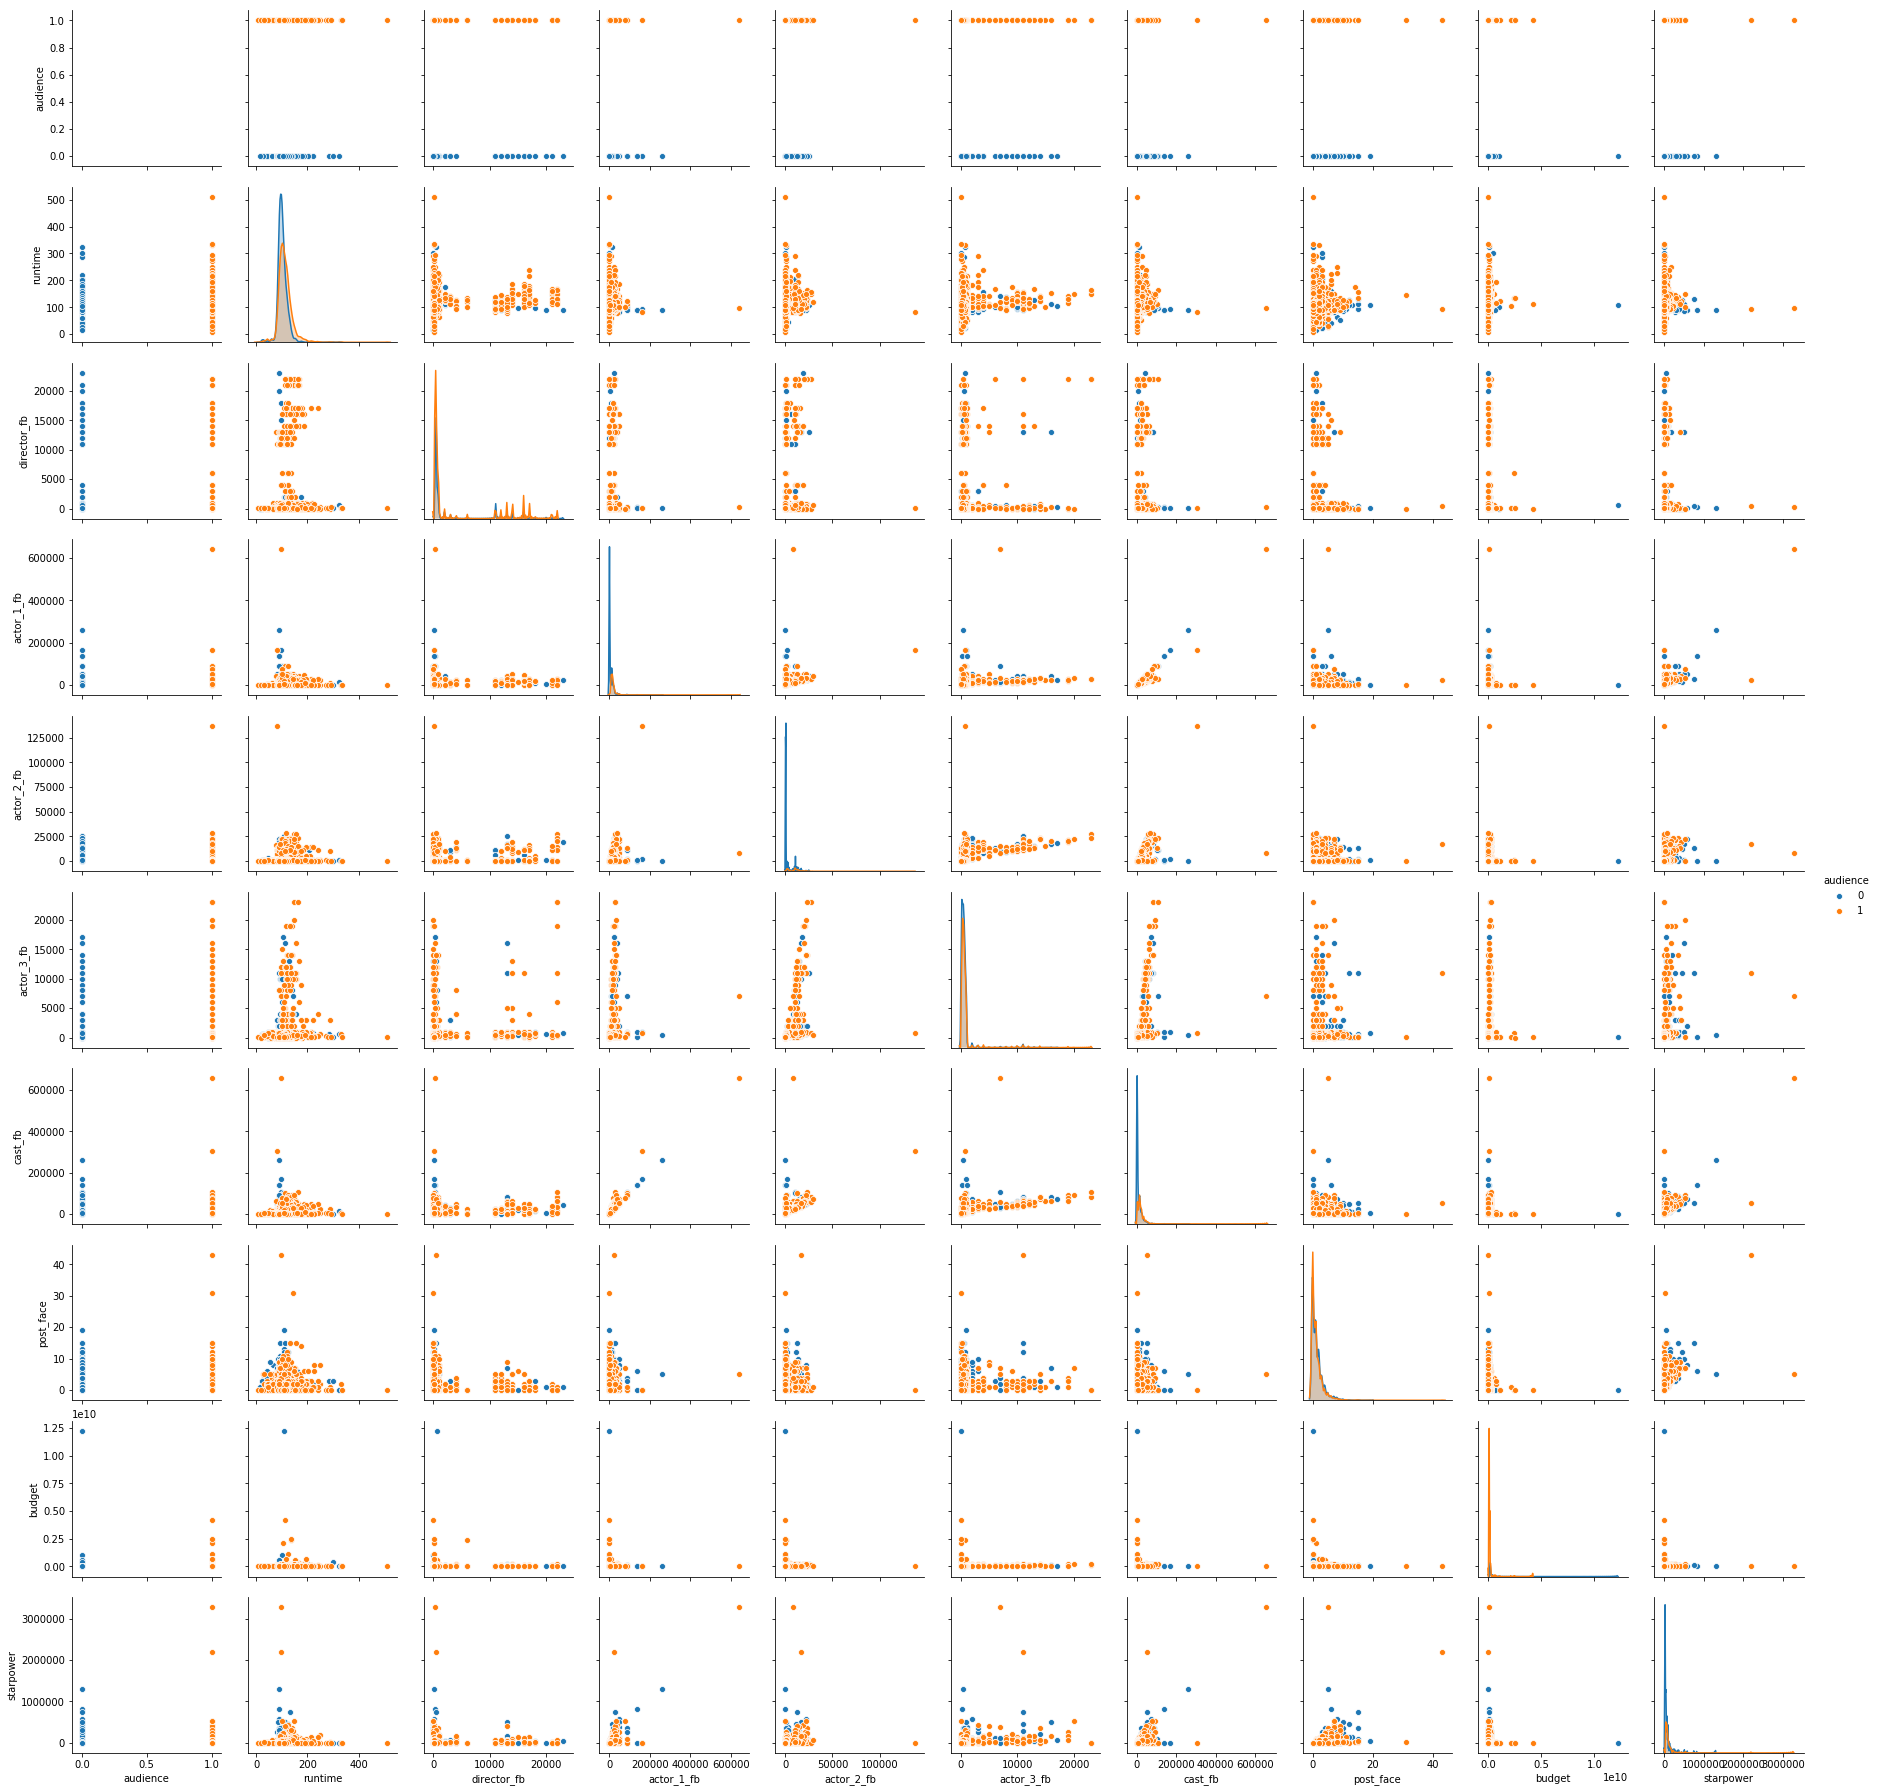

In [8]:
aud_num = aud_table.loc[:,['audience','runtime','director_fb', 'actor_1_fb', 'actor_2_fb',
       'actor_3_fb', 'cast_fb', 'post_face', 'budget','starpower']]
sns.pairplot(aud_num,hue='audience')

Find the most divisive categorical features by seeing what percentage of films with that genre were liked by audeinces.

In [14]:
aud_kat = aud_table.columns.difference(['audience','runtime','director_fb', 'actor_1_fb', 'actor_2_fb',
       'actor_3_fb', 'cast_fb', 'post_face', 'budget','starpower'])
for cat in aud_kat :
    that_cat = aud_table[aud_table[cat]==1]
    total_cat = len(that_cat)
    liked = len(that_cat[that_cat.audience==1])
    percent_liked = liked/total_cat
    if percent_liked>.6 or percent_liked < .4 :
            print(cat)
            print(percent_liked)
    else :
        aud_table = aud_table.drop(cat,axis=1)

Biography
0.8447653429602888
Documentary
0.9038461538461539
Drama
0.6718213058419243
Film-Noir
1.0
Game-Show
0.0
History
0.7903225806451613
Horror
0.2987012987012987
Music
0.7121212121212122
Musical
0.7719298245614035
News
1.0
Short
0.6666666666666666
Sport
0.7239263803680982
War
0.7487437185929648
Western
0.7058823529411765
aspect_ratio_other
0.6196911196911197
country_UK
0.6461916461916462
decade_70s
0.7623762376237624
decade_80s
0.6530612244897959
decade_90s
0.6152815013404825
decade_old
0.8818897637795275
language_andre
0.7683823529411765
rating_andre
0.6513761467889908


Again get rid of poster faces because it seems probably least relevant.

In [15]:
aud_table = aud_table.drop('post_face',axis=1)

In [17]:
aud_table.columns

Index(['audience', 'runtime', 'director_fb', 'actor_1_fb', 'actor_2_fb',
       'actor_3_fb', 'cast_fb', 'budget', 'Biography', 'Documentary', 'Drama',
       'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 'Musical',
       'News', 'Short', 'Sport', 'War', 'Western', 'rating_andre',
       'decade_70s', 'decade_80s', 'decade_90s', 'decade_old',
       'aspect_ratio_other', 'language_andre', 'country_UK', 'starpower'],
      dtype='object')

### Class Imbalance

A small imbalance in our classes.

In [20]:
aud_table.audience.value_counts()[1]/(aud_table.audience.value_counts()[1]+aud_table.audience.value_counts()[0])

0.5516463689670726

Check if there are more than 100 observations for categoricals (if not, don't consider this feature bc we don't have as much info as we would like).

In [22]:
for kat in aud_table.columns :
    number_kat = len(aud_table[aud_table[kat]==1])
    if number_kat > 0 :
        if number_kat < 100 :
            aud_table = aud_table.drop(kat,axis=1)
        else :
            print(kat)
            print(number_kat)
            print(number_kat/len(aud_table))

audience
2446
0.5516463689670726
Biography
277
0.06247180875056382
Documentary
104
0.02345511953089761
Drama
2328
0.5250338294993234
History
186
0.04194857916102842
Horror
462
0.10419485791610285
Music
198
0.044654939106901215
Musical
114
0.02571041948579161
Sport
163
0.036761389264772217
War
199
0.044880469102390616
rating_andre
436
0.09833107803337844
decade_70s
101
0.02277852954442941
decade_80s
245
0.05525484889490302
decade_90s
746
0.16824537663509248
decade_old
127
0.02864230942715381
aspect_ratio_other
518
0.11682453766350925
language_andre
272
0.06134415877311682
country_UK
407
0.09179070816418583


### Collinearity

Here we remove a highly collinear feature, cast_fb which was closely related to the other actor facebooks.

In [29]:
aud_table = aud_table.drop('cast_fb',axis=1)

In [30]:
aud_table.corr()

,audience,runtime,director_fb,actor_1_fb,actor_2_fb,actor_3_fb,budget,Biography,Documentary,Drama,...,War,rating_andre,decade_70s,decade_80s,decade_90s,decade_old,aspect_ratio_other,language_andre,country_UK,starpower
audience,1.000000,0.212994,0.094217,0.017155,0.034233,0.016416,-0.015737,0.152143,0.109754,0.254060,...,0.085909,0.066223,0.064692,0.049316,0.057548,0.114027,0.049762,0.111410,0.060437,-0.000697
runtime,0.212994,1.000000,0.161993,0.088581,0.122038,0.112087,0.062528,0.184473,-0.072674,0.240506,...,0.193344,-0.132640,0.073110,0.046875,0.064419,0.099575,-0.149803,0.060087,0.032422,0.032839
director_fb,0.094217,0.161993,1.000000,0.097000,0.115500,0.117587,0.018586,0.063548,-0.015143,0.032438,...,0.023844,-0.044972,0.072390,0.035615,0.037013,0.005648,-0.036017,-0.036802,-0.048620,0.019717
actor_1_fb,0.017155,0.088581,0.097000,1.000000,0.386435,0.245633,0.021372,0.025107,-0.058595,-0.003363,...,-0.007090,-0.105478,-0.028381,-0.036728,-0.007809,-0.064243,-0.080833,-0.082863,-0.018043,0.700817
actor_2_fb,0.034233,0.122038,0.115500,0.386435,1.000000,0.537934,0.038034,0.023322,-0.052076,-0.002170,...,0.000350,-0.105964,-0.030497,-0.052080,-0.011784,-0.058537,-0.096340,-0.093817,-0.030556,0.247582
actor_3_fb,0.016416,0.112087,0.117587,0.245633,0.537934,1.000000,0.040242,-0.000973,-0.048917,-0.040900,...,-0.002830,-0.089380,-0.026955,-0.044655,-0.022976,-0.048500,-0.073527,-0.086417,-0.029559,0.286115
budget,-0.015737,0.062528,0.018586,0.021372,0.038034,0.040242,1.000000,-0.015956,-0.023148,-0.022475,...,0.014045,-0.044116,-0.022441,-0.023722,-0.005575,-0.028726,-0.037709,0.097321,-0.020573,0.007822
Biography,0.152143,0.184473,0.063548,0.025107,0.023322,-0.000973,-0.015956,1.000000,0.033884,0.217528,...,0.079075,-0.025781,-0.020673,0.010990,-0.011469,0.005956,-0.047465,-0.003854,0.098680,-0.005743
Documentary,0.109754,-0.072674,-0.015143,-0.058595,-0.052076,-0.048917,-0.023148,0.033884,1.000000,-0.130118,...,0.031183,0.159014,-0.003685,-0.030958,-0.057752,-0.026613,0.194154,0.022482,-0.002819,-0.020791
Drama,0.254060,0.240506,0.032438,-0.003363,-0.002170,-0.040900,-0.022475,0.217528,-0.130118,1.000000,...,0.156005,0.025914,-0.015221,-0.064506,0.037818,0.030652,-0.001360,0.117048,0.042720,-0.029877


### Feature General Info
There are 8 continuous numerical features and 17 categorical features.

In [31]:
aud_table.columns

Index(['audience', 'runtime', 'director_fb', 'actor_1_fb', 'actor_2_fb',
       'actor_3_fb', 'budget', 'Biography', 'Documentary', 'Drama', 'History',
       'Horror', 'Music', 'Musical', 'Sport', 'War', 'rating_andre',
       'decade_70s', 'decade_80s', 'decade_90s', 'decade_old',
       'aspect_ratio_other', 'language_andre', 'country_UK', 'starpower'],
      dtype='object')

### This is a binary classification.

# PRE-MODELING Q&A :
### What kind of model do I want to build?
Preference is given to predictive power rather than interpretability given that we don't want to know *why* a film is a good movie; rather we want to know whether or not a movie will be good.
### What metrics do I want to use?
Two! Precision and recall, each preferred for a separate model. <br /> 

There is the "casual moviegoer/indie moviemaker model", which cares more about precision than recall because we want to make sure that the good movies are, in fact, good (can't waste our money, now can we?!). But! At the same time, we don't want to go beneath 20-25% recall, because at that point we are missing too many good movies. We must be part of the Zeitgeist. <br />

Then, there is the "movie-lover/studio-exec model", which cares more about recall than precision because we want to make sure we're not missing any good movies (money to buuuurn). But! At the same time, we don't want beneath 33% precision; below that things aren't financially feasible for the movie-exec and the movie-lover starts bitching on Reddit about how all movies are shit these days.

In [38]:
pd.to_pickle(aud_table,'./aud_edad.pkl')